## Code 3

I'm considering a 2D arrangement of atoms and seeing how it behaves under the molecular dynamics simulation under the Microcanonical ensemble (NVE = conserved)

In [133]:

import random
import numpy as np
import matplotlib.pyplot as plt
Natom = 25 #total number of atoms
Nmax = 25 
Tinit = 2.0 #initial temperature

dens = 1.0
t1 = 0

x = np.zeros(Nmax)
y = np.zeros(Nmax)

vx = np.zeros(Nmax)
vy = np.zeros(Nmax)

fx = np.zeros((Nmax,2))
fy = np.zeros((Nmax,2))

L = int(1.0*Natom**0.5)
atoms = []



In [134]:
def twelverean():
    s = 0.0
    for i in range(1,13): #function to produce gaussian distribution for velocity
        s += random.random()
    return s/12.0 - 0.5

In [135]:
def initial():
    i = -1
    for ix in range(0,L):
        for iy in range(0,L):
            i = i+1
            x[i] = ix
            y[i] = iy
            vx[i] = twelverean() #drawing the velocities from a Gaussian distribution
            vy[i] = twelverean()
            vx[i] = vx[i]*np.sqrt(Tinit) 
            vy[i] = vy[i]*np.sqrt(Tinit)
    for j in range(0,Natom):
        xc = 2*x[j] - 4
        yc = 2*y[j] - 4
        atoms.append([xc,yc])

In [136]:
initial()

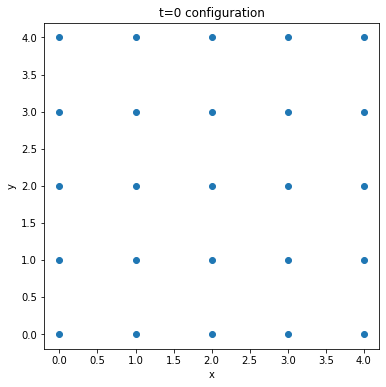

In [139]:
plt.figure(figsize=[6,6])
plt.scatter(x,y) #inital configuration of the atoms
plt.xlabel("x")
plt.ylabel("y")
plt.title("t=0 configuration")
plt.savefig("init_config.pdf")

In [142]:
def sign(a,b):
    if (b>=0.0):
        return np.abs(a)
    else:
        return -np.abs(a)
    
def Forces(t,w,PE,PEorW):
    r2cut = 9.0
    PE = 0
    for i in range(0,Natom):
        fx[i][t] = fy[i][t] = 0.0
    for i in range(0,Natom-1):
        for j in range(i+1,Natom):
            dx = x[i]-x[j]
            dy = y[i]-y[j]
            
            if(abs(dx)>0.50*L): 
                dx = dx - sign(L,dx)
            if(abs(dy)>0.50*L):
                dy = dy - sign(L,dy)
            r2 = dx*dx + dy*dy
            
            if(r2<r2cut):
                if(r2 == 0.):
                    r2 = 0.0001
                invr2 = 1.0/r2
                wij = 48*(invr2**3 - 0.5)*invr2**3 #lennard-jones potential
                fijx = wij*invr2*dx
                fijy = wij*invr2*dy
                fx[i][t] = fx[i][t] + fijx
                fy[i][t] = fy[i][t] + fijy
                fx[j][t] = fx[j][t] - fijx
                fx[j][t] = fx[j][t] - fijy
                
                PE = PE + 4.0 *(invr2**3)*((invr2**3)-1.0)
                
                w = w + wij
    if(PEorW == 1):
        return PE
    else:
        return w
    
    
def timevolution(time): #one time step in evolution
    avT = 0.0
    avP = 0.0
    Pavg = 0.0
    avKE = 0.0
    avPE = 0.0
    t1 = 0
    PE = 0.0
    h = 0.031
    hover2 = h/2.0
    
    KE=0.0
    w=0.0
    initial()
    
    for i in range(0,Natom):
        KE = KE+(vx[i]*vx[i]+vy[i]*vy[i])/2.0
    
    PE = Forces(t1,w,PE,1)

    
    for l in range(10):
        for i in range(0,Natom):
            PE = Forces(t1,w,PE,1)
            x[i] = x[i] + h*(vx[i] + hover2*fx[i][t1]) #verlet-algorithm
            y[i] = y[i] + h*(vy[i] + hover2*fy[i][t1])
            
            if (x[i]<=0.0):  #employing the boundary conditions
                x[i] = x[i] + L
            if (x[i]>=L):
                x[i] = x[i] - L
            if (y[i]<=0.0):
                y[i] = y[i] + L
            if (y[i]<=0.0):
                y[i] = y[i] - L
            
            xc = 2*x[i] - 4
            yc = 2*y[i] - 4
            atoms[i]=[xc,yc]
            
    PE = 0.0
    t2 = 1
    PE = Forces(t2,w,PE,1)
    KE = 0.0
    w = 0.0
    for i in range(0,Natom):
        vx[i]=vx[i]+hover2*(fx[i][t1]+fx[i][t2]) #verlet-algorithm
        vy[i]=vy[i]+hover2*(fy[i][t1]+fy[i][t2])
        KE = KE + (vx[i]*vx[i]+vy[i]*vy[i])/ 2
        
    w=Forces(t2,w,PE,2)
    P=dens*(KE+w)
    T=KE/Natom
    
    avT = avT + T
    avP = avP + P
    avKE = avKE + KE #Kinetic Energy at t
    avPE = avPE + PE #Pootential Energy at t
    
    time = time+1 
    t = time
    
    if(t==0):
        t=1
    
    Pavg = avP/t
    eKavg = avKE/t
    
    
    ePavg = avPE/t
    Tavg =avT/t
    
    pre=(int)(Pavg*1000)
    Pavg=pre/1000.0
    
    kener=(int)(eKavg*1000)
    eKavg=kener/1000.0
    
    pener = (int)(ePavg*1000)
    ePavg = pener/1000.0
    
    
    tempe = (int)(Tavg*1000000)
    Tavg = tempe/1000000.0
    

    return t,eKavg,ePavg
    
    
    
    
    
    
    
    

In [145]:
T = np.zeros(500)
T[0] = 0
K = np.zeros(500)
V = np.zeros(500)


for i in range(500):
    t,k,p = timevolution(T[i])
    K[i] = k
    V[i] = p
    if(i!=499):
        T[i+1] = t

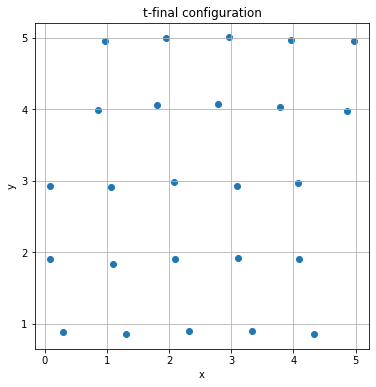

In [151]:
plt.figure(figsize=[6,6])
plt.scatter(x,y) #inital configuration of the atoms
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.title("t-final configuration")
plt.savefig("final_config.pdf")

The total energy fluctuates by a small amount and remains conserved to the average total energy

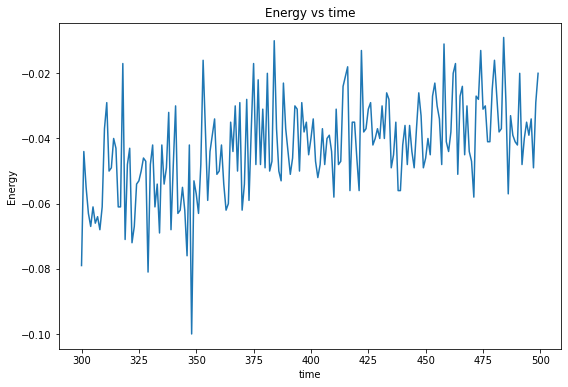

In [154]:
plt.figure(figsize=[9,6])
plt.plot(T[300:],K[300:]+V[300:])
plt.title("Energy vs time")
plt.xlabel("time")
plt.ylabel("Energy")

plt.savefig("Evt.pdf")

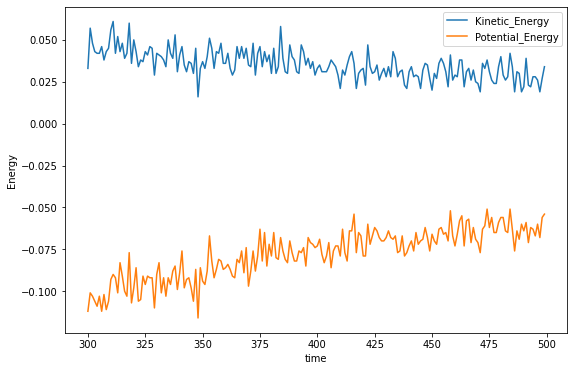

In [155]:
plt.figure(figsize=[9,6])
plt.plot(T[300:],K[300:],label="Kinetic_Energy")
plt.plot(T[300:],V[300:],label="Potential_Energy")
plt.xlabel("time")
plt.ylabel("Energy")
plt.legend()
plt.savefig("KEandUvt.pdf")